In [1]:
import numpy as np
import pandas as pd
from scipy import sparse
import matplotlib.pyplot as plt
from scipy.io import loadmat

from coclust.coclustering import CoclustMod, CoclustSpecMod, CoclustInfo
from coclust.visualization import (plot_reorganized_matrix, plot_cluster_top_terms, 
                                   plot_cluster_sizes, plot_confusion_matrix)

from sklearn.metrics.cluster import normalized_mutual_info_score as nmi
from sklearn.metrics import confusion_matrix

## Gobal parameters

In [2]:
## Global parameters
# Set data (CLASSIC4, PUBMED5, PUBMED10)
data_name = "PUBMED5"
# Set coclustering (CoclustMod, CoclustSpecMod, CoclustInfo)
coclust_type = "CoclustMod"

## Define functions

In [3]:
# Load the document-term data, the true labels and the terms
def load_data_labels(data_name, verbose = False):
    
    if data_name == "PUBMED5":
        # Doc-term
        doc_term_counts = sparse.load_npz('../../../../../data/PubMed5/PubMed5_docWordMat.npz')
        # Labels
        labels_df = pd.read_csv('../../../../../data/PubMed5/PubMed5_label.csv', 
                             usecols = [0], delim_whitespace = True)
        labels = labels_df.values.flatten()
        # Terms
        terms_df = pd.read_csv('../../../../../data/PubMed5/PubMed5_wordList.csv', 
                             usecols = [0], delim_whitespace = True)
        terms = terms_df.values.flatten()
        # Permutation
        tmp_perm = np.random.RandomState(seed=42).permutation(doc_term_counts.shape[0])
        #np.take(doc_term_counts, tmp_perm,axis=0,out = doc_term_counts)
        doc_term_counts = doc_term_counts[tmp_perm,:]
        labels = [labels[i] for i in tmp_perm.tolist()]
           
    if data_name == "CLASSIC4":
        # DATA: http://www.dataminingresearch.com/index.php/tag/dataset-2
        # Set data file path
        filename = "../../../../data/CLASSIC4/classic4_docbyterm.txt"
        # Open the file and read content
        myfile = open(filename, "rb")
        content = myfile.read().decode() #Read every content of myfile
        myfile.close()
        # Split content to build a matrix
        content = content.split("\n")
        meta = content[0].split(" ")
        doc_term_counts = np.zeros((int(meta[0])-1, int(meta[1])))
        
        for i in range(1, len(content)-1):
            meta = content[i].split(" ")
            if len(meta) == 3:
                row = int(meta[0])
                if row >= 1553:
                    row -=1
                doc_term_counts[row-1, int(meta[1])-1] = int(meta[2])
        
        # Load the true labels
        filename = "../../../../data/CLASSIC4/classic4_documents.txt"
        labels_df = pd.read_csv(filename, usecols = [1], delim_whitespace = True, header = None)
        # il y a un header
        labels = labels_df.values.flatten()
        labels = labels[:len(labels)-1]
        ## Permutation
        tmp_perm = np.random.RandomState(seed=42).permutation(doc_term_counts.shape[0])
        np.take(doc_term_counts, tmp_perm, axis = 0, out = doc_term_counts)
        labels = [labels[i] for i in tmp_perm.tolist()]
        
        # Load terms
        filename = "../../../../data/CLASSIC4/classic4_terms.txt"
        #dicbyterm2
        myfile = open(filename, "rb")
        content = myfile.read().decode()
        myfile.close()
        terms = content.split("\n")
        terms = np.asarray(terms)
    
    return doc_term_counts, labels, terms

def plot_cluster_top_terms_V2(in_data, all_terms, nb_top_terms, model):
    """Plot the top terms for each cluster.

    Parameters
    ----------
    in_data : numpy array or scipy sparse matrix, shape=(n_samples, n_features)
    all_terms: list of string
        list of all terms from the original data set
    nb_top_terms: int
        number of top terms to be displayed per cluster
    model: :class:`coclust.coclustering.BaseDiagonalCoclust`
        a co-clustering model


    Example
    -------
    >>> plot_cluster_top_terms(in_data, all_terms, nb_top_terms, model)

    .. plot::

        from coclust.visualization import plot_cluster_top_terms
        from coclust.io.data_loading import load_doc_term_data
        from coclust.evaluation.internal import best_modularity_partition

        path = '../../../datasets/classic3_coclustFormat.mat'
        doc_term_data = load_doc_term_data(path)

        min_cluster_nbr = 2
        max_cluster_nbr = 9
        range_n_clusters = range(min_cluster_nbr, (max_cluster_nbr + 1))

        best_coclustMod_model, _ = \
            best_modularity_partition(doc_term_data['doc_term_matrix'],
                                      range_n_clusters, 1)
        n_terms = 10
        plot_cluster_top_terms(doc_term_data['doc_term_matrix'],
                               doc_term_data['term_labels'],
                               n_terms,
                               best_coclustMod_model)

    """

    if all_terms is None:
        logger.warning("Term labels cannot be found. Use input argument "
                       "'term_labels_filepath' in function "
                       "'load_doc_term_data' if term labels are available.")
        return

    x_label = "number of occurences"
    plt.subplots(figsize=(8, 8))
    plt.subplots_adjust(hspace=0.200)
    plt.suptitle("      Top %d terms" % nb_top_terms, size=15)
    number_of_subplots = model.n_clusters

    for i, v in enumerate(range(number_of_subplots)):
        # Get the row/col indices corresponding to the given cluster
        row_indices, col_indices = model.get_indices(v)
        # Get the submatrix corresponding to the given cluster
        cluster = model.get_submatrix(in_data, v)
        # Count the number of each term
        p = cluster.sum(0)
        p = np.asmatrix(p)
        print(p.shape, type(p))
        t = p.getA().flatten()
        #t = p
        # Obtain all term names for the given cluster
        tmp_terms = np.array(all_terms)[col_indices]
        # Get the first n terms
        max_indices = t.argsort()[::-1][:nb_top_terms]

        pos = np.arange(nb_top_terms)

        v = v + 1
        ax1 = plt.subplot(number_of_subplots, 1, v)
        ax1.barh(pos, t[max_indices][::-1])
        ax1.set_title("Cluster %d (%d terms)" % (v, len(col_indices)), size=11)

        plt.yticks(.4 + pos, tmp_terms[max_indices][::-1], size=9.5)
        plt.xlabel(x_label, size=9)
        plt.margins(y=0.05)
        #_remove_ticks()
        plt.tick_params(axis='both', which='both', bottom='True', top='False',
                        right='False', left='False')

    # Tight layout often produces nice results
    # but requires the title to be spaced accordingly
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)

    plt.show()


## Load the document-term data

In [4]:
data, labels, terms = load_data_labels(data_name)
n_clusters = len(np.unique(labels))
print(terms[8184],terms[8185])

increa increasingli


In [8]:
terms

array(['aa', 'aaberg', 'aac', ..., 'zygomycosi', 'zymograph',
       'zymographi'], dtype=object)

## Make TF-IDF transform

In [5]:
## Make the TF-IDF matrix
#from sklearn.feature_extraction.text import TfidfTransformer
#my_norm = 'l2'
#s_idf = True
#s_tf = False
#transformer = TfidfTransformer(norm = my_norm, smooth_idf = s_idf, sublinear_tf = s_tf)
#data_tfidf = transformer.fit_transform(data)
#data = data_tfidf

## Make a co-clustering

In [9]:
model = None
predicted_row_labels = None
predicted_column_labels = None

print("Co-clustering:", coclust_type)
if coclust_type == "CoclustMod":
    model = CoclustMod(n_clusters = n_clusters)
    model.fit(data)
    print("--> Modularity:", model.modularity)
    predicted_row_labels = model.row_labels_
    predicted_column_labels = model.column_labels_
    
elif coclust_type == "CoclustSpecMod":
    model = CoclustSpecMod(n_clusters = n_clusters)
    model.fit(data)
    predicted_row_labels = model.row_labels_
    predicted_column_labels = model.column_labels_

elif coclust_type == "CoclustInfo":
    model = CoclustSpecMod(n_clusters = n_clusters)
    model.fit(data)
    predicted_row_labels = model.row_labels_
    predicted_column_labels = model.column_labels_

Co-clustering: CoclustMod


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/coclust/coclustering/coclust_mod.py:93: FutureWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  check_array(X, accept_sparse=True, dtype="numeric", order=None,


--> Modularity: 0.2802044706732014


## Evaluate the (document) co-clustering

In [10]:
print("--> NMI:", nmi(labels, predicted_row_labels, average_method='arithmetic'))

--> NMI: 0.43703637256456845


In [12]:
data.toarray().shape

numpy.ndarray

## Plot the reorganized matrix

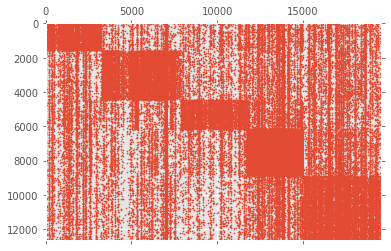

In [7]:
plot_reorganized_matrix(data, model, precision = 2, markersize = 0.6)

## Plot various information on clusters

(1, 3243) <class 'numpy.matrix'>
(1, 4640) <class 'numpy.matrix'>
(1, 3824) <class 'numpy.matrix'>
(1, 3230) <class 'numpy.matrix'>
(1, 4581) <class 'numpy.matrix'>


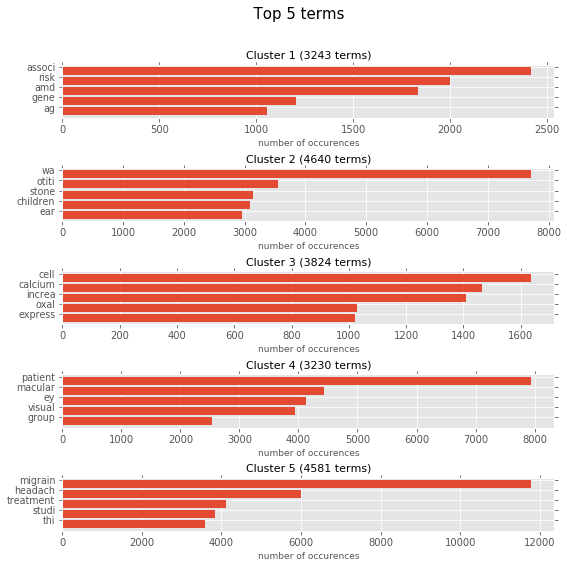

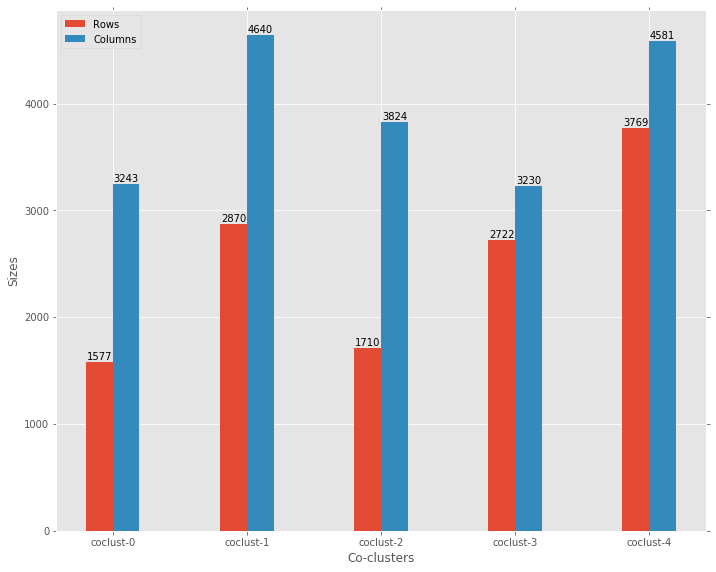

In [8]:
# Plot the top terms
plot_cluster_top_terms_V2(in_data = data, all_terms = terms, nb_top_terms = 5, model = model)

# Plot cluster sizes
plot_cluster_sizes(model)

## Top terms cosine similarity

In [10]:
#from sklearn.feature_extraction.text import TfidfTransformer
#
## Make the TF-IDF matrix
#my_norm = 'l2'
#s_idf = True
#s_tf = False
#transformer = TfidfTransformer(norm = my_norm, smooth_idf = s_idf, sublinear_tf = s_tf)
#data_tfidf = transformer.fit_transform(data)

In [13]:
import numpy as np
import csv
from sklearn.preprocessing import normalize

n_clust = 1
n_top = 20

# Extract a co-cluster matrix data_c
row_indices, col_indices = model.get_indices(n_clust)
data_c = model.get_submatrix(data, n_clust)

# Count the number of each term within the co-cluster matrix
t = data_c.sum(axis = 0)

# Obtain all term names for the co-cluster matrix
tmp_terms = [terms[i] for i in col_indices]
#print(tmp_terms)

# Get the first n terms sorted by deacreasing frequency within the co-cluster
max_indices = (-t).argsort() #argsort is by increasing
max_indices = max_indices.tolist()[0][:n_top]
#print(max_indices)
top_terms = [tmp_terms[i] for i in max_indices]

####save the ntop terms for other embeddings
c = csv.writer(open("../../../../../data/PubMed5/Frequency/top_terms_amd.csv", "w"))
c.writerow(top_terms)

####save the ntop matching frquenceies of the terms 
cfreq = csv.writer(open("../../../../../data/PubMed5/Frequency/freq_amd.csv", "w"))
freq = [0] * n_top
for i in range(n_top):
    freq[i] = t.tolist()[0][max_indices[i]]
    cfreq.writerow([top_terms[i],freq[i]])


# Normalize the column vectors to b of L2 unit length
#print(max_indices)
data_c_top = data_c[:,max_indices]
data_c_top_norm = normalize(data_c_top, axis = 0, norm = 'l2')

# Compute the similarity (ie., weighted adjacency matrix)
S_c = data_c_top_norm.T @ data_c_top_norm

NameError: name 'model' is not defined

In [19]:
print((S_c.todense() > 0.3))

[[ True  True  True  True  True  True  True  True  True  True  True False
  False  True  True False  True False False  True]
 [ True  True False  True  True  True False  True  True False False  True
  False  True False False False False False False]
 [ True False  True False False False  True False False  True False False
  False False  True False False False False False]
 [ True  True False  True False  True False False  True False False False
  False  True False False False False  True False]
 [ True  True False False  True  True False  True False False False False
  False False False False False False False False]
 [ True  True False  True  True  True False  True  True False False False
  False  True False False False False False False]
 [ True False  True False False False  True False False False False False
  False False False False False False False False]
 [ True  True False False  True  True False  True False False False False
  False False False False False False False False]


## Generate a pariwise graph representation

In [24]:
import igraph

# Make a graph from the adjacency matrix
g = igraph.Graph.Weighted_Adjacency((S_c.todense() > 0.3).tolist(), mode = "undirected")

# Set words as vertices label
g.vs["name"] = top_terms
g.vs["label"] = g.vs["name"]
g.vs["color"] = "pink"

# Set size as vertices size by frequence of term in documents
size_vertex = [0] * n_top
for i in range(n_top):
    size_vertex[i] = t.tolist()[0][max_indices[i]]
    #print(size_vertex[i])
size_vertex_norm = norm = [float(i)/(sum(size_vertex) - size_vertex[0]) * 700 for i in size_vertex]

g.vs["size"] = size_vertex_norm

# Set cosine similarity as edge width
edge_w = [0]*len(g.get_edgelist())
for ie, (i,j) in enumerate(g.get_edgelist()):
    if i == j:
        edge_w[ie] = 0
    else:
        edge_w[ie] = -np.log(S_c[i,j]) * 2

edge_w_color = [""]*len(g.get_edgelist())

for ie, edge_value in enumerate(edge_w):
    if (edge_value > 2.4):
        edge_w_color[ie] = "#126600" 
    elif (edge_value > 2.35 and edge_value < 2.4):
        edge_w_color[ie] = "#25cc00"
    else:
        edge_w_color[ie] = "#2eff00"
        
g.es["weight"] = edge_w
g.es["width"] = g.es["weight"]
g.es["color"] = edge_w_color

# plot the graph
igraph.summary(g)
out = igraph.plot(g, margin= 50, bbox = (900,900))
out.save('../../../../../output/graph_co_clust_freq.png')
#igraph.Graph.write_gml(g,"testgraph_10.gml")

IGRAPH UNW- 20 56 -- 
+ attr: color (v), label (v), name (v), size (v), color (e), weight (e), width (e)
